In [1]:
import pandas as pd
import os 
import arrow as ar
import matplotlib.pyplot as plt
import seaborn as sns
from pyplotz.pyplotz import PyplotZ #一个优化matplotlib函数操作的package
import numpy as np
plt.style.use('fivethirtyeight')
from palettable.colorbrewer.sequential import Blues_9,BuGn_9,Greys_3,PuRd_5#三种配色的调色板
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
os.chdir('H:\IJCAI')
pltz=PyplotZ()

train=pd.read_csv('./data/train.csv')
test=pd.read_csv('./data/test.csv')

## 1 简介

本文使用python对[IJCAI-18 阿里妈妈搜索广告转化预测](https://tianchi.aliyun.com/competition/introduction.htm?spm=5176.100066.0.0.7bacd780V3AzWb&raceId=231647)大赛数据进行了探索与分析，以可视化的方式做了一点微小的工作，供大家参考，文中有错误的内容望读者及时指正。

搜索广告的转化率，作为衡量广告转化效果的指标，从广告创意、商品品质、商店质量等多个角度综合刻画用户对广告商品的购买意向，即广告商品被用户点击后产生购买行为的概率。本次比赛依托电商CTR数据为基础，旨在通过广告商品信息、用户信息、上下文信息和店铺信息等4类数据，对转化率进行预估以辅助商家决策。

本次比赛为参赛选手提供了5类数据（基础数据、广告商品信息、用户信息、上下文信息和店铺信息）如下。基础数据表提供了搜索广告最基本的信息，以及“是否交易”的标记。广告商品信息、用户信息、上下文信息和店铺信息等4类数据，提供了对转化率预估可能有帮助的辅助信息。

* 基础数据：各类数据的编号
* 广告商品信息：商品的具体信息
* 用户信息：用户基本个人信息
* 上下文信息：广告展示页面的基本信息

用于初赛的数据包含了若干天的样本。最后一天的数据用于结果评测，对选手不公布；其余日期的数据作为训练数据，提供给参赛选手；。

在上述各张数据表中，绝大部分样本包含了完整的字段数据，也有少部分样本缺乏特定字段的数据。如果一条样本的某个字段为“-1”，表示这个样本的对应字段缺乏数据。

## 2 数据探索

### 2.1 基础数据
字段|解释
- | :-: | -: 
instance_id|样本编号，Long
is_trade|是否交易的标记位，Int类型；取值是0或者1，其中1 表示这条样本最终产生交易，0 表示没有交易
item_id|广告商品编号，Long类型
user_id|用户的编号，Long类型
context_id|上下文信息的编号，Long类型
shop_id|店铺的编号，Long类型

In [5]:
print('数据集一共有'+str(len(train))+'个样本')

print('标签的比例为'+str(len(train[train.is_trade==0])/len(train[train.is_trade==1])))

数据集一共有478138个样本
标签的比例为52.00277131138455


In [9]:
print('数据中有'+str(len(train['item_id'].unique()))+'不用的广告商品,以及'+str(len(train['shop_id'].unique()))+'个不同的商铺')

数据中有10075不用的广告商品,以及3959个不同的商铺


In [11]:
#探查下出现频率最高的各类型id
for x in ['instance_id','is_trade','item_id','user_id','context_id','shop_id']:
    print(train[x].value_counts().head())

5479907258807096112    3
3370133319712542740    3
2535273059737073357    2
4984307821968110563    2
6031880284089240838    2
Name: instance_id, dtype: int64
0    469117
1      9021
Name: is_trade, dtype: int64
7571023501622243456    3001
2986722878397696833    2836
5410526681843914464    2578
2079092401639430105    2515
2709839111509701702    2448
Name: item_id, dtype: int64
7201324926905945581    65
9077306189515288541    56
4221535911244811523    53
6040154960559072464    50
7147341411281829756    46
Name: user_id, dtype: int64
290808226164722964     3
7259819519976136023    3
393440996556281300     2
6603062751043810606    2
8100475734761363134    2
Name: context_id, dtype: int64
6597981382309269962    11278
1932086538588242822     9702
8953967780295706657     8353
2025576994711098052     5172
4215742678121737516     4296
Name: shop_id, dtype: int64


* is_trade负正比例不均匀，大约为52
* instance_id有少量重复脏数据，考虑直接删除
* 有大量重复item、shop，商品符合电商长尾分布规律
* 一共有3959家店铺，店铺shop_id6597981382309269962出现11278次
* 一共有10075个商品，商品item_id7571023501622243456出现3001次
* user、context有少量重复出现数据

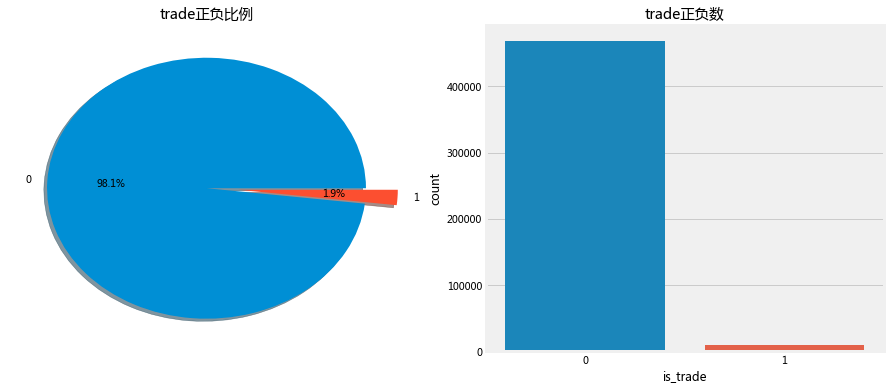

In [13]:
#使用饼图,看看样本正负比例
f,ax=plt.subplots(1,2,figsize=(14,6))
train['is_trade'].value_counts().plot.pie(explode=[0,0.2],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('trade正负比例')
ax[0].set_ylabel('')
sns.countplot('is_trade',data=train,ax=ax[1])
ax[1].set_title('trade正负数')
plt.show()

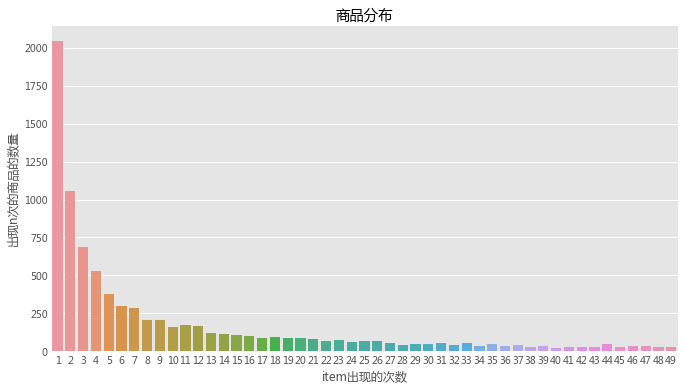

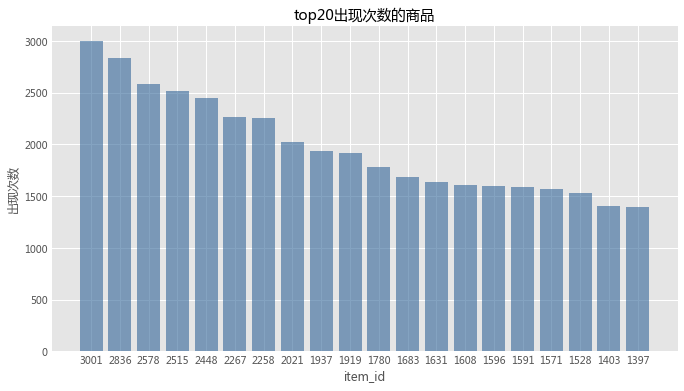

In [290]:
fig, axis1 = plt.subplots(1,1,figsize=(10,6))
item_num=pd.DataFrame({'item_id_num':train['item_id'].value_counts().values})
sns.countplot(x='item_id_num',data=item_num[item_num['item_id_num']<50])
axis1.set_xlabel('item出现的次数')
axis1.set_ylabel('出现n次的商品的数量')
axis1.set_title('商品分布')


fig, axis1 = plt.subplots(1,1,figsize=(10,6))

item_value=pd.DataFrame(train.item_id.value_counts()).reset_index().head(20)
axis1.set_xlabel('item_id')
axis1.set_ylabel('出现次数')
axis1.set_title('top20出现次数的商品')
y_pos = np.arange(len(item_value))

plt.bar(y_pos, item_value['item_id'], color=(0.2, 0.4, 0.6, 0.6))
pltz.xticks(y_pos, item_value['item_id'])
pltz.show()

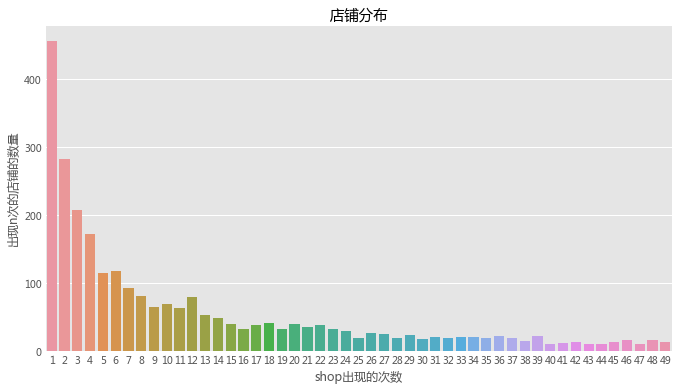

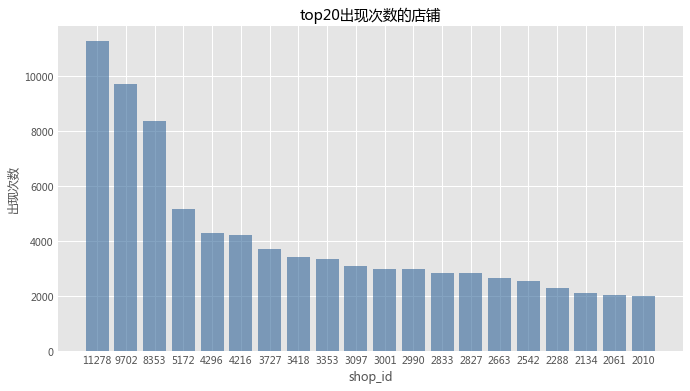

In [292]:
fig, axis1 = plt.subplots(1, 1, figsize=(10, 6))
shop_num = pd.DataFrame({'shop_id_num': train['shop_id'].value_counts().values})
sns.countplot(x='shop_id_num', data=shop_num[shop_num['shop_id_num'] < 50])
axis1.set_xlabel('shop出现的次数')
axis1.set_ylabel('出现n次的店铺的数量')
axis1.set_title('店铺分布')

fig, axis1 = plt.subplots(1, 1, figsize=(10, 6))

shop_value = pd.DataFrame(train.shop_id.value_counts()).reset_index().head(20)
axis1.set_xlabel('shop_id')
axis1.set_ylabel('出现次数')
axis1.set_title('top20出现次数的店铺')
y_pos = np.arange(len(shop_value))

plt.bar(y_pos, shop_value['shop_id'], color=(0.2, 0.4, 0.6, 0.6))
pltz.xticks(y_pos, shop_value['shop_id'])
pltz.show()

### 2.2 用户信息

字段|解释
- | :-: | -: 
user_gender_id|用户的预测性别编号，Int类型；0表示女性用户，1表示男性用户，2表示家庭用户
user_age_level|用户的预测年龄等级，Int类型；数值越大表示年龄越大
user_occupation_id|用户的预测职业编号，Int类型
user_star_level|用户的星级编号，Int类型；数值越大表示用户的星级越高

In [14]:
for x in ['user_gender_id','user_age_level','user_occupation_id','user_star_level']:
    print(train[x].value_counts().head(5))

 0    360817
 1     94070
-1     12902
 2     10349
Name: user_gender_id, dtype: int64
1003    169449
1004    126131
1002     70175
1005     56608
1006     30190
Name: user_age_level, dtype: int64
 2005    300036
 2002    146917
 2004     23803
 2003      6418
-1          964
Name: user_occupation_id, dtype: int64
3006    82009
3003    74578
3005    67440
3002    62921
3004    61769
Name: user_star_level, dtype: int64


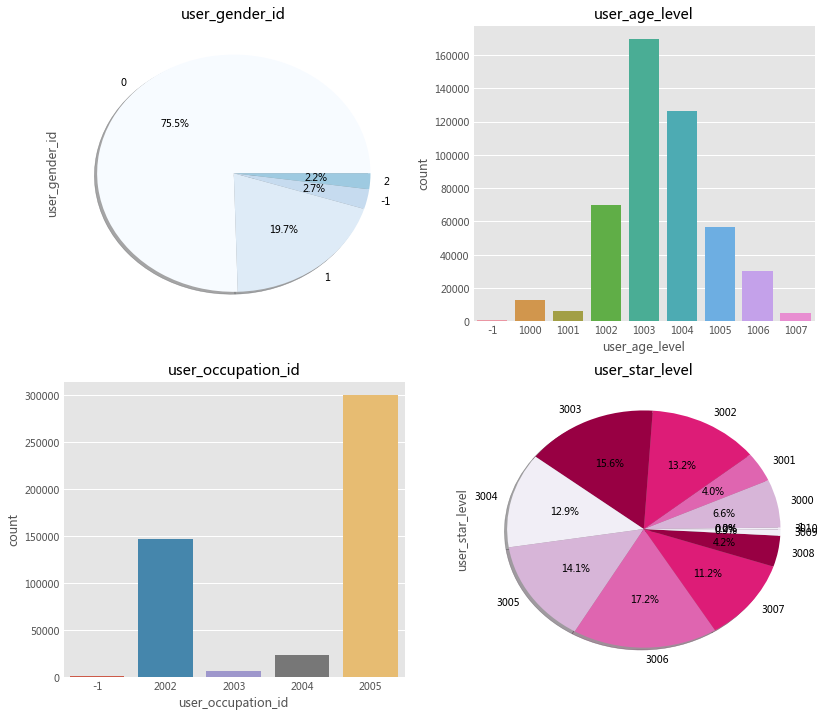

In [298]:
f,ax=plt.subplots(2,2,figsize=(12,12))
train['user_gender_id'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0][0],shadow=True,colors=Blues_9.hex_colors)
ax[0][0].set_title('user_gender_id')

sns.countplot('user_age_level',data=train,ax=ax[0][1])
ax[0][1].set_title('user_age_level')

sns.countplot('user_occupation_id',data=train,ax=ax[1][0])
ax[1][0].set_title('user_occupation_id')

train['user_star_level'].value_counts().sort_index().plot.pie(autopct='%1.1f%%',ax=ax[1][1],shadow=True,colors=PuRd_5.hex_colors)
ax[1][1].set_title('user_star_level')

plt.show()

### 2.3 店铺信息

字段|解释
- | :-: | -: 
shop_review_num_level|店铺的评价数量等级，Int类型；取值从0开始，数值越大表示评价数量越多
shop_review_positive_rate|店铺的好评率，Double类型；取值在0到1之间，数值越大表示好评率越高
shop_star_level|店铺的星级编号，Int类型；取值从0开始，数值越大表示店铺的星级越高
shop_score_service|店铺的服务态度评分，Double类型；取值在0到1之间，数值越大表示评分越高
shop_score_delivery|店铺的物流服务评分，Double类型；取值在0到1之间，数值越大表示评分越高
shop_score_description|店铺的描述相符评分，Double类型；取值在0到1之间，数值越大表示评分越高

In [88]:
for x in ['shop_review_num_level','shop_star_level']:
    print(train[x].value_counts())

17    81437
16    79295
15    65954
14    50727
18    50617
13    31051
20    24914
21    22855
12    18673
19    16230
11    14008
10     8598
9      5484
8      3089
7      1849
6      1343
22      619
5       578
23      353
4       266
2        87
3        80
1        20
0         7
25        4
Name: shop_review_num_level, dtype: int64
5013    82641
5014    81596
5015    73992
5012    73611
5011    34356
5018    25075
5010    24487
5017    23243
5016    19239
5009    18191
5008     8480
5007     5500
5006     3087
5005     1459
5003     1266
5004      863
5002      477
5020      357
5000       81
5019       70
5001       60
4999        7
Name: shop_star_level, dtype: int64


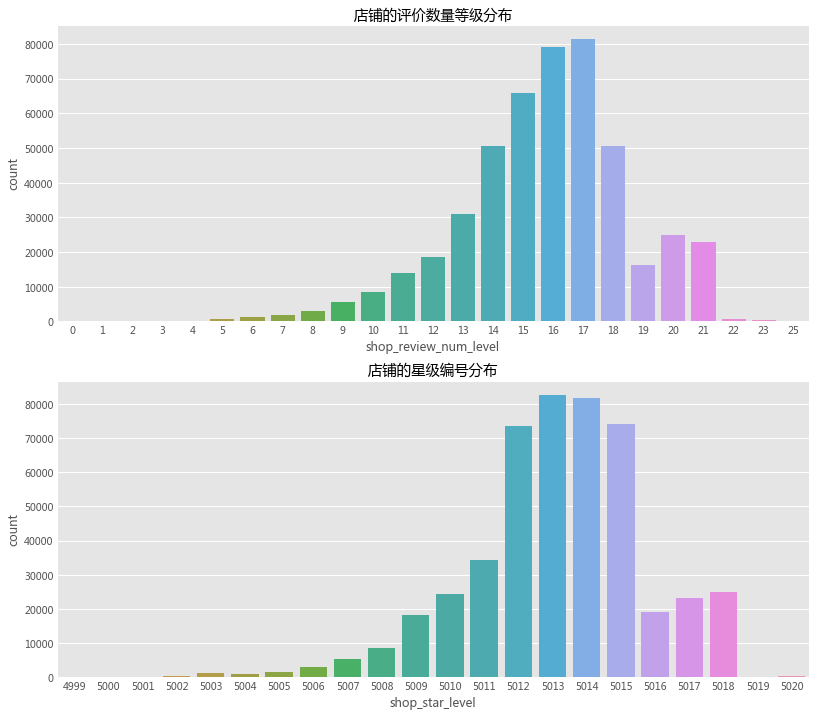

In [303]:
f,ax=plt.subplots(2,1,figsize=(12,12))
sns.countplot('shop_review_num_level',data=train,ax=ax[0])
ax[0].set_title('店铺的评价数量等级分布')

sns.countplot('shop_star_level',data=train,ax=ax[1])
ax[1].set_title('店铺的星级编号分布')

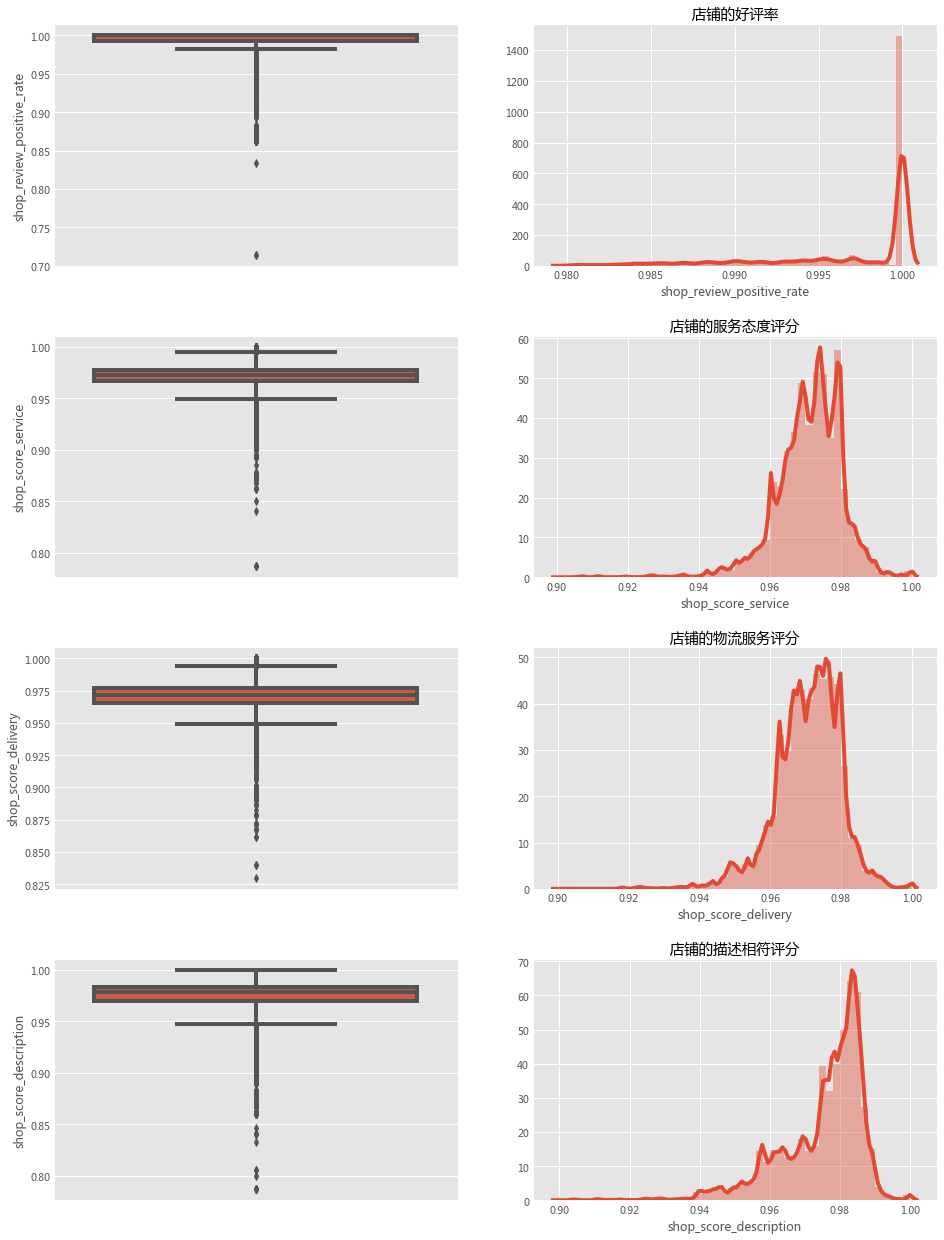

In [307]:
plt.style.use('ggplot')
f,ax=plt.subplots(4,2,figsize=(14,18))
plt.tight_layout(5)
sns.boxplot(y=train['shop_review_positive_rate'][train['shop_review_positive_rate']!=-1],ax=ax[0][0])
sns.distplot(train['shop_review_positive_rate'][train['shop_review_positive_rate']>0.98],ax=ax[0][1])
ax[0][1].set_title('店铺的好评率')


sns.boxplot(y=train['shop_score_service'][train['shop_score_service']!=-1],ax=ax[1][0])
sns.distplot(train['shop_score_service'][train['shop_score_service']>0.9],ax=ax[1][1])
ax[1][1].set_title('店铺的服务态度评分')


sns.boxplot(y=train['shop_score_delivery'][train['shop_score_delivery']!=-1],ax=ax[2][0])
sns.distplot(train['shop_score_delivery'][train['shop_score_delivery']>0.9],ax=ax[2][1])
ax[2][1].set_title('店铺的物流服务评分')


sns.boxplot(y=train['shop_score_description'][train['shop_score_description']!=-1],ax=ax[3][0])
sns.distplot(train['shop_score_description'][train['shop_score_description']>0.9],ax=ax[3][1])
ax[3][1].set_title('店铺的描述相符评分')


In [16]:
pd.DataFrame(train[train>0].min())

0
instance_id                3.823219e+12
item_id                    6.964907e+14
item_brand_id              1.519409e+15
item_city_id               1.962573e+17
item_price_level           1.000000e+00
item_sales_level           1.000000e+00
item_collected_level       1.000000e+00
item_pv_level              1.000000e+00
user_id                    2.477979e+13
user_gender_id             1.000000e+00
user_age_level             1.000000e+03
user_occupation_id         2.002000e+03
user_star_level            3.000000e+03
context_id                 5.541611e+11
context_timestamp          1.537200e+09
context_page_id            4.001000e+03
shop_id                    1.543560e+15
shop_review_num_level      1.000000e+00
shop_review_positive_rate  7.142857e-01
shop_star_level            4.999000e+03
shop_score_service         7.866667e-01
shop_score_delivery        8.300000e-01
shop_score_description     7.866667e-01
is_trade                   1.000000e+00
item_category_list0        7.908383e+18
item_category_list1        2.273127e+16
year                       2.018000e+03
month                      9.000000e+00
day                        1.700000e+01
hour                       1.000000e+00

## 2.4 广告商品信息
字段|解释
- | :-: | -: 
item_id|广告商品编号，Long类型
item_category_list|广告商品的的类目列表
item_property_list|广告商品的属性列表
item_brand_id|广告商品的品牌编号，Long类型
item_city_id|广告商品的城市编号，Long类型
item_price_level|广告商品的价格等级，Int类型；取值从0开始，数值越大表示价格越高
item_sales_level|广告商品的销量等级，Int类型；取值从0开始，数值越大表示销量越大
item_collected_level|广告商品被收藏次数的等级，Int类型；取值从0开始，数值越大表示被收藏次数越大
item_pv_level|广告商品被展示次数的等级，Int类型；取值从0开始，数值越大表示被展示次数越大

In [118]:
for x in ['item_brand_id','item_city_id','item_price_level','item_sales_level','item_collected_level','item_pv_level']:
    print(train[x].value_counts())

7838285046767229711    69746
7066302540842412840    13823
5051039799137810159    13045
448955875785543916     10116
739382823914881928      6542
6793286343174833903     5280
1902568530584691432     4605
4609398715869550725     4235
6597576831450166037     4216
8188723660812005813     3739
5818352635473521241     3730
3801992748557162347     3474
7024713306861377790     3453
7166307405309656478     3195
3765442984647241130     3178
1212158767298395095     3097
1842327023449366624     3033
5368019250815240955     2990
6553461951829665552     2764
3884267719846612071     2678
3697251094784296011     2645
7393038778026345793     2607
4940851772115583463     2492
2441922225904422164     2456
3321064285232298680     2388
665010924190078800      2375
8036402958319042519     2369
6874110308416919683     2347
4219436286513843074     2339
2707400123518269628     2288
                       ...  
3095754226004529341        1
5454033227514511696        1
4688766976726863845        1
23545905335358

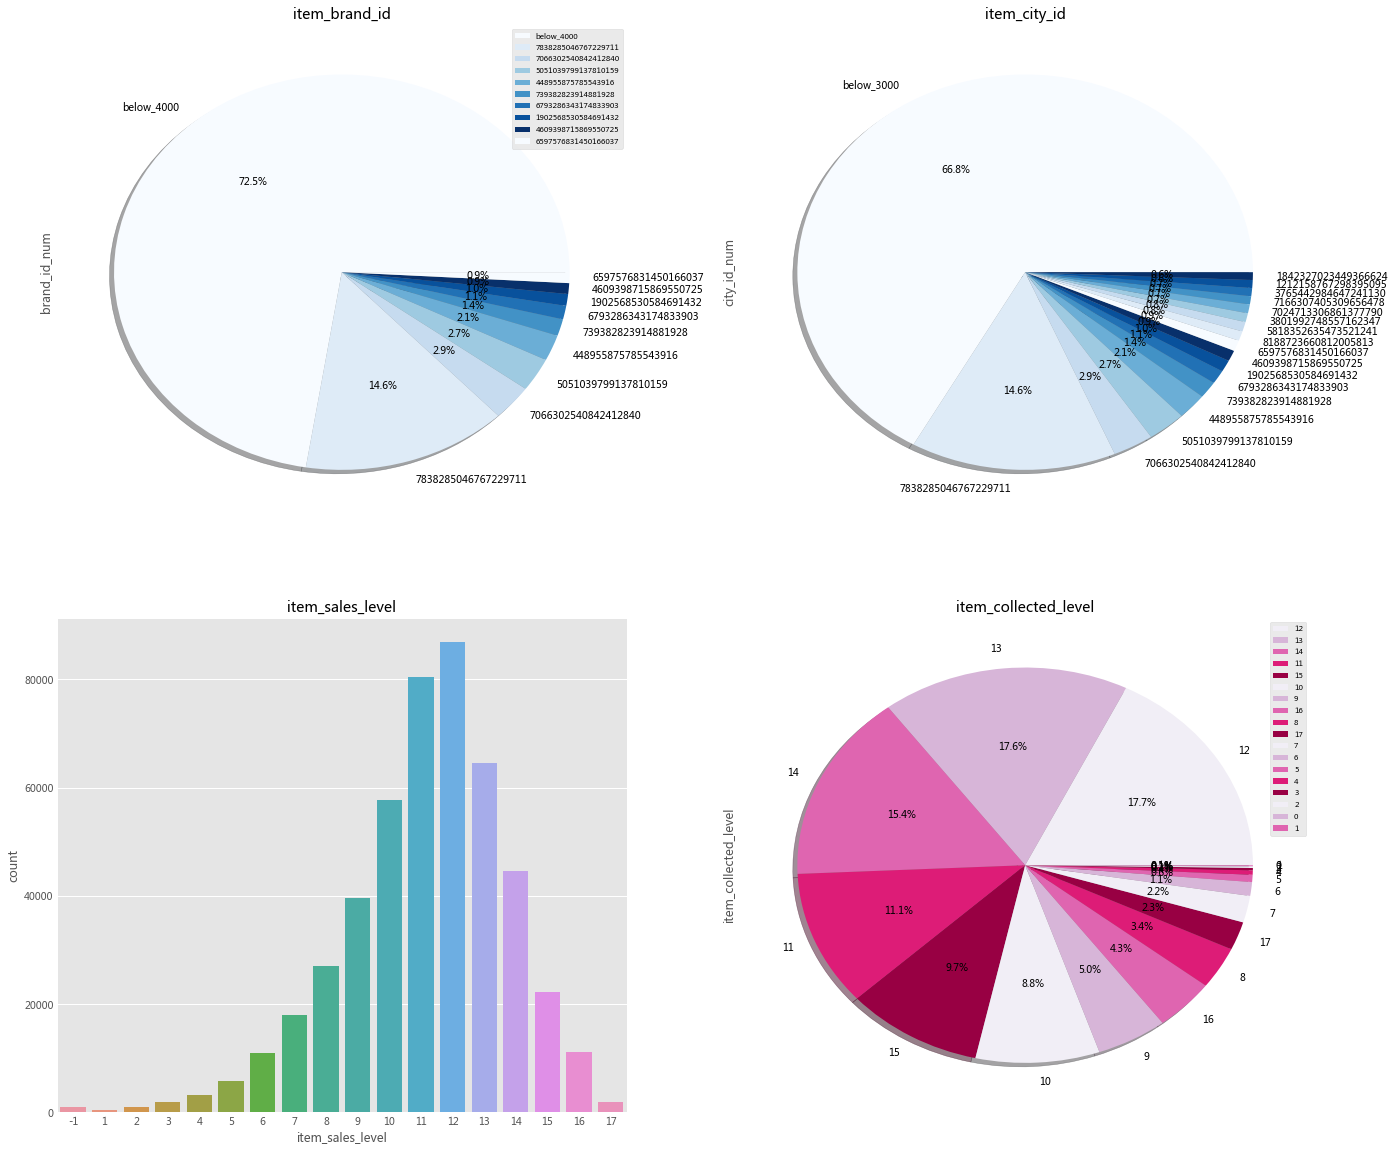

In [277]:
f,ax=plt.subplots(2,2,figsize=(20,20))

item_brand_id_num=pd.DataFrame({'brand_id_num':train['item_brand_id'].value_counts()}).reset_index()
brand_value=pd.DataFrame({'brand_id_num':item_brand_id_num['brand_id_num'][item_brand_id_num['brand_id_num']<4000].sum()},index=[0])
brand_value['index']='below_4000'
brand_value=pd.concat([brand_value,item_brand_id_num[item_brand_id_num['brand_id_num']>=4000]])
pd.Series(data=brand_value.set_index('index')['brand_id_num']).plot.pie(autopct='%1.1f%%',ax=ax[0][0],shadow=True,colors=Blues_9.hex_colors)
ax[0][0].set_title('item_brand_id')
ax[0][0].legend(fontsize=7.5)
#sns.countplot('item_city_id',data=train,ax=ax[0][1])


item_city_id_num=pd.DataFrame({'city_id_num':train['item_brand_id'].value_counts()}).reset_index()
city_value=pd.DataFrame({'city_id_num':item_city_id_num['city_id_num'][item_city_id_num['city_id_num']<3000].sum()},index=[0])
city_value['index']='below_3000'
city_value=pd.concat([city_value,item_city_id_num[item_brand_id_num['brand_id_num']>=3000]])
pd.Series(data=city_value.set_index('index')['city_id_num']).plot.pie(autopct='%1.1f%%',ax=ax[0][1],shadow=True,colors=Blues_9.hex_colors)
ax[0][1].set_title('item_city_id')

sns.countplot('item_sales_level',data=train,ax=ax[1][0])
ax[1][0].set_title('item_sales_level')

train['item_collected_level'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1][1],shadow=True,colors=PuRd_5.hex_colors)
ax[1][1].set_title('item_collected_level')
ax[1][1].legend(fontsize=7.5)
plt.show()